In [367]:
# David Omrai
# 18.12.2022
from IPython.display import Image
from IPython.display import Video

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from sources.tsplot import tsplot
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

# Crawler
import requests as rq
from bs4 import BeautifulSoup
# type: ignore


# POES Radiation Belt Indices

### Why is it so big problem?
Back in 1950s the radiation belts had little effect on ordinary people

Today they are utterly crucial to our high-tech society. Hundreds of satellites used for everything from wather prediction, to gps and television routinely skim the belts subjecting themselves to energetic particles that can demage solar panels and and short-circuit sunsitive electronics

During geomagnetic storms when the belts are swollen by solar activity whole fleets of satellites can be engulfed imperiling the technological underpinnings of daily life on the planet below.

The radiation belt storm probes directly address these problems. 

The biggest mysteries of the radiation belts is the crazy way they react to solar storms... almost anything can happen. When a storm cloud from the sun hits the radiation belts, they often respond in counter-intuitive ways. 

One possible outcome is that the radiation belts fill with energetic particles, such as the potent killer electrons that worry mission planners. But just as often the oposite happens. A solar storms can cause the belts to lose their killer particles, temporarily making them a safer place and sometimes nothing happens. The belts remain completely unchanged... This is visualized in the following image.

<center>
<img src="images/solar.png" alt="solar">
</center>
 
During the storms the probes can sample electric and magnetic fields, count the number of energetic particles and detect plasma waves of many frequencies!!!

<center>
<img src="images/sungraph.png" alt="sun-grap">
</center>

https://youtu.be/Qk8Qp-71Cus

## Where and what are the NOAA's Polar Orbiting Environmental Satellites?
These satelites carry a suite of instruments that measure the flux (flow) of energetic ions and electrons at the altitude of the satellite. This environment varies as a result of solar and geomagnetic activity. 

Beginning with the **NOAA-15** satelite, an upgraded version of the Space Environment Monitor **(SEM-2)** has been flown.

The **SEM-2** instruments differ significantly from the earlier **SEM-1**, there has been a complete revision to the data processing and archiving processes. A number of improvements have also been included. Among these are incorporating up-to-date satellite orbit information and magnetic field models in the calculation of various magnetic coordinates, and improved data quality control.

The **Total Energy Detector (TED)** is designed to measure the *energy flux* carried by auroral particles, both *positively charged ions* *(protons) and electrons*, into the polar atmoshpere. The magnitude and spatial extent of this evergy flux are good measures of both the level of auroral acivity and atmospheric response to that energy input.

The **Medium Energy Proton and Electron Detector (MEPED)** includes a set of *solid-state energic particle detectors* that monitor the *intensities of protons* and *electrons* over range extending from *30 keV to more than 200 MeV*. Particles having those energies include the radiation belt populations, solar particles entering the atmosphere can produce significant and widespread degradation in short-wave radio propagation. In extreme cases even *radio blackouts!!!* The energetic particles also contribute to astronaut radiation exposure, especially on high inclination orbit mission during energetic solar particle event.

And for the where are these satalites, there is a animation showing their location throughout the day. The subsolar point shows the center of the enlightened area from the Sun and the terminator of its borders.

<center>
<img src="images/STK_PoesConstellation_w19.gif" alt="cycle">
</center>


#### Data representation
In this notebook I'll be foccusing on the MEPED aka Medium Enery Proton and Electron Detector and it's in-situ measuremements of the space particle radiation on the POES/MetOp satelites.

Before I go any further let's describe how the data look and how can we visualize them.

There are there belts that satellites measure. First one is the *inner belt* that begins some 400 miles above Earth's surface and extends up to 6000 miles. The second, *outer belt* stretches from 8,400 to 36,000 miles above Earth's surface.

The inner belt is filled mostly with protons and, to lesser extent, electrons and the occasional atomic nuclei. Its size and population is relatively stable.

The outer belt consist almost exclusively of energetic electrons and varies dramatically in size and shape. Both the solar wind and Earth's upper atmosphere, the ionosphere, supply particles to the belts. Some events couse more of these particles to sweep in and the outer belt swells in size only to diminish again, gradually, minutes to days later.

Important scientific question is how different solar events affect the radiation belts. Observations so far have shown highly variable responses to outside events. Major space weather storms sweeping through the belts have been known to cause particle enhancement, particle losses, and even no change at all.

<center>
<img src="images/vamodel-radiation_belts.jpg" alt="solar">
</center>

https://www.nasa.gov/mission_pages/rbsp/science/index.html


#### Few words about what is the Index that is used for the time's serie
RBA index is based on a dataset that globally reflects radiation belt dynamic state as a reference for the entire outer zone. On one hand, for low energies (below 100 keV) and in the inner belt, electron begavior is driven mainly by convection, so a ranking with Kp seems to be enough; Thus a belt index is not necessary. On the other hand, for higher energy (above 100 keV), the internal acceleration process can dominate the electron dynamic so the definition of an index makes sense. The lowest energy above 100 keV available in IPODE on a longer time than a solar cycle is from > 300 keV channel on the NPOES spacecraft series.

To define this new indes the response of the 90', > 300 keV electron sensor aboard NPOES-15 and METOP-A is one meteorogical spacecraft developed by ESA and EUMETSAT on the same orbit as the NPOES constellation since 2006 and with the same NOAA SEM2 detector on board. Boath datasets are daily averaged around L = 4 over the spacecraft time period, respectively, form 1998 to 2012 NPOES-15, 2006 to 2012 METOP-A.

Processing data at the L = 4 region provides a good overview of the behavior of the outer electron belt because it is located in the heart of this one. Flux enhancements in this region are maximum during geomagnetic storm with a good signal-to-noise-ratio. The same index could be defined at greater L ( for example L = 6), but fluxes are deeply weaker. An average between both will not have manny interest...

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6742637

with this part of the paper I wanted to show what should we imagine under index. It is a value that represents particle count rate for data channel. In the dataset, if this rate is less than 10 per second, the value is set to -1.0000, which means unsignificant.

Also to mention these detectors have to settings, 0 deg and 90 deg (also Omnidirectional)

### Zpracování úlohy
- V predchozi casti jsem priblizil data, kterymi se budu v teto uloze dale zabivat. Pro zachovani vyrazu a definic jsem pouzil anglicky jazyk, dale v dokumentu budu jiz pouzivat cestinu.
- V prvni casti nejdrive stahnu data ze stranek NOAA. Predevsim se zameruji na jeden ze satelitu, ktere obihaji kolem zeme. Timto satelitem je NOAA_19, ktery lze videt v gifu vyse. Pro tento satelit plati, ze ma data od roku 2013, coz u ostatnich nebylo. 
- Na tomto satelitu jak jsem jiz popisoval se nachazi nekolik senzoru, ktere maji ruzne nastaveni, diagonalni ci vertikalni. Tyto a dalsi informace o datech dale v praci popisi.
- Pro zpracovani casove rady, kterych je timto satelitem zaznamenano nekolik, si vybiram pouze jeden senzor. Pro kazdy senzor jsou zaznamenana ctverice dat. Tyto data odpovidaji pasum, ze kterych tyto informace cerpaji. Vyse jsem uvedl ze se kolem zeme nachazi trojice pasu. Tri zaznami odpovidaji prave merezi z techto pasu, ten dalsi odpovida celkovemu mereni, skrz vsechny pasy. Ten vsak je ve formatu, ktery v teto praci nebudu zpracovavat, nevyrazne hodnoty popisuje hodnotou -1.0, coz zanedbava informaci z mereni.
- Nyni se jiz pustim do prace

In [323]:
# crawling the data

url_no_19 = "https://satdat.ngdc.noaa.gov/sem/poes/data/belt_indices/noaa19/bi_N19_{}.txt"

result_data = ""

for year in range(2013, 2022 + 1):
    response = rq.get(url_no_19.format(year))
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        pre = soup.find('pre')
        
        result_data += response.text.split('\n', 21)[21]
        

- V predchozi casti programu s nacivam data ze stranek NOAA. data jsou zde v txt fomatu nyni pouze stahuji cely balik dat. 
- Data ukladam do stringu result_data

In [324]:
# process the data 
data = re.sub(' +', ';', result_data.lstrip())
data = re.sub('\n;', '\n', data)

- V datech nahranim mezery symbolem ; pomoci regulaniho vyrazu
- Nakonec nahradim konce radku, kde jsem taktez vlozil oddelovac, tam neni treba

In [325]:
header = "day;month;year;sensor_id;tbi;ibi;sbi;obi"

df = pd.DataFrame([x.split(';') for x in data.split('\n')],
                  columns=[x for x in header.split(';')])
df = df.dropna()

- V teto casti si vytvarim dataframe s osmi sloupci
- day - den zaznamu
- month - mesic zaznamu
- year - rok zaznamu
- sensor_id - id senzoru
- tbi - total belt index (vypocitana z ostatnich indexu)
- ibi - inner belt index (nejblizsi pas zeme)
- sbi - sloth belt index (mezi pas zeme)
- obi - outer belt index (vzdaleny pas zeme)
- Nakonec z dat odstranuji vsechny nan hodnoty


In [326]:
# Change data formats of the columns
for col_name in ['day', 'month', 'year', 'sensor_id']:
    df[col_name] = df[col_name].astype(int)
    
for col_name in ['tbi', 'ibi', 'sbi', 'obi']:
    df[col_name] = df[col_name].astype(float)

- V teto casti pouze pretypovavam data (ze stringu)

In [327]:
# Create-the-unique data
df.loc[(df.year == 2016) & (df.month == 1) & (df.day == 1) & (df.sensor_id == 0)]

,day,month,year,sensor_id,tbi,ibi,sbi,obi
23078,1,1,2016,0,14.6492,14.7635,2.0735,22.7507


- Testovani, zdali vse funguje jak ma
- Z dat si vybiram zaznam z 1.1.2016 senzoru 0

- Neco malo k senzorum.
    - 0 >30 keV Electrons (0 deg detector)
    - 1 >30 keV Electrons (90 deg detector)
    - 2 >100 keV Electrons (0 deg detector)
    - 3 >100 keV Electrons (90 deg detector)
    - 4 >300 keV Electrons (0 deg detector)
    - 5 >300 keV Electrons (90 deg detector)
    - 6 30-80 keV Protons (0 deg detector)
    - 7 30-80 keV Protons (90 deg detector)
    - 8 80-250 keV Protons (0 deg detector)
    - 9 80-250 keV Protons (90 deg detector)
    - 10 250-250 keV Protons (0 deg detector)
    - 11 250-250 keV Protons (90 deg detector)
    - 12 800-2500 keV Protons (0 deg detector)
    - 13 800-2500 keV Protons (90 deg detector)
    - 14 2500-6900 keV Protons (0 deg detector)
    - 15 2500-6900 keV Protons (90 deg detector)
    - 16 >6.9 MeV Protons (0 deg detector)
    - 17 >6.9 MeV Protons (90 deg detector)
    - 18 16-70 MeV Protons (Omnidirectional)
    - 19 35-70 MeV Protons (Omnidirectional)
    - 20 70-235 MeV Protons (Omnidirectional)
    - 21 140-275 MeV Protons (Omnidirectional)

In [328]:
df['time_stamp'] = df.apply(lambda row: "{}-{}-{}".format(int(row.day), row.month, row.year), axis=1)


- Pro vykreslovani dat si vytvarim casove razitko, unikatni pro kazdy zaznam

### První zpracovávání časové řady
- Pro zacatky prace na casove rade jsem si zkousel zakladni pritupy
- Pred vybranim si z celkoveho poctu 22*4 casovych rad si vybiram tu, ktera bude "nejzajimavejsi"
- Toto jsem udelal pomoci nasledujici casti kodu, ve smycce jsem si vykresilil "tbi" vsech senzoru a z nich vybral jednu casovou radu
- U casovych rad me zajima nastaveni senzoru a jaky to bude mit vliv na model
- Planem tedy je, vybrat si jednu radu, v praci vybrat nejlepsi model a pak jej zkusit na senzoru nastaveneho vertikalne, ci horizontalne

In [329]:
# for sensor_id in range(0, 22):
#     df[df.sensor_id == sensor_id][['time_stamp', 'tbi']].plot()

/tmp/ipykernel_6320/3854621541.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  series = df[df.year == 2022][df.sensor_id == 2]['ibi']


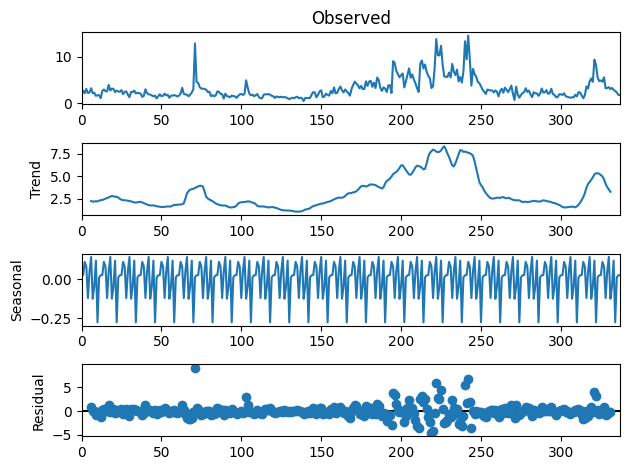

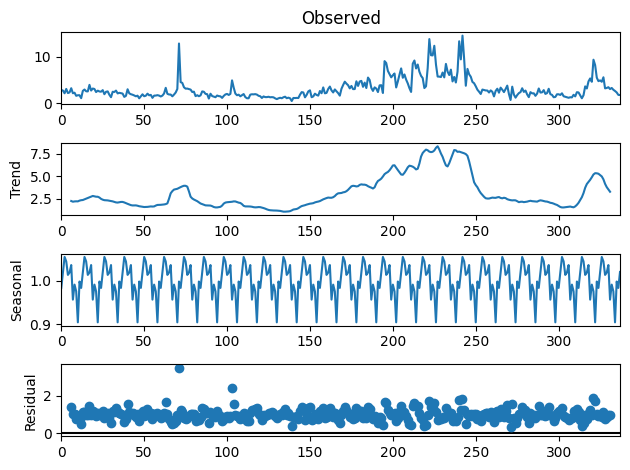

In [330]:
series = df[df.year == 2022][df.sensor_id == 2]['ibi']

result_m = seasonal_decompose(series.values, period=12, model='multiplicative')
result_a = seasonal_decompose(series.values, period=12, model='adictive')
result_a.plot()
result_m.plot()
plt.show()

- Ze vsech casovych rad jsem si vybral tu ze senzoru 2 (0 deg >100keV)
- V predchozi casti jsem provedl uvodni pruzkum casove rady, z grafu lze videt, ze rada ma urcity trend, taktez i sezonost.
- V residuals lze dale pozorovat, ze ne veskera informace byla extrahovana
- Tyto informace pomuzi dale v programu s rozhodnuti, jak k teto casove rade pristupovat
- Z dat grafu lze pozorovat, ze bude problem s **lokalni variaci v case** to se pokusim resit ruznymi transformacemi
- Vyse jsou uvedene dva grafy, jeden pro aditivni model a druhy pro multiplikativni model, moc z toho nelze rici, jen mozna ze multiplikativni ma lepsi sezoni a residualni cast

In [331]:
from statsmodels.tsa.stattools import acf
resid_acf_m = acf(result_m.resid, nlags=10, missing='drop')
sos_m = np.sum(resid_acf_m**2)

resid_acf_a = acf(result_a.resid, nlags=10, missing='drop')
sos_a = np.sum(resid_acf_a**2)

print("sum of squared residualcs ACF:{} | {}".format(sos_m, sos_a))

sum of squared residualcs ACF:1.36004896061535 | 1.7068533617747237


- V predchozi casti zkousim pocitat ACF multiplikativniho a aditivniho modelu
- **Lze pozorovat, ze multiplikativni ma lehce lepsi hodnotu**

/tmp/ipykernel_6320/3055514482.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfc = df[df.year == 2022][df.sensor_id == 2]['ibi']
/tmp/ipykernel_6320/3055514482.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.scatter(dfc[i+1:], dfc[:-(1+i)])


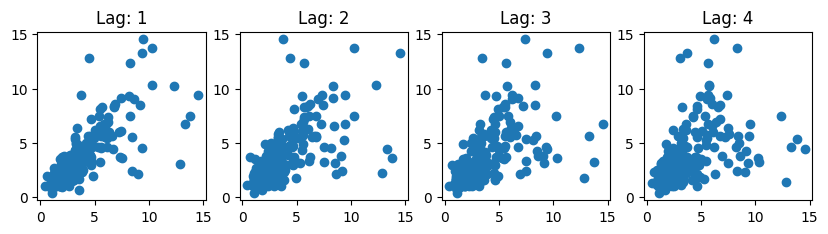

In [332]:
dfc = df[df.year == 2022][df.sensor_id == 2]['ibi']
# lag = 1
# plt.scatter(dfc[lag:], dfc[:-lag])
# plt.show()

plt.figure(figsize=(10, 6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.scatter(dfc[i+1:], dfc[:-(1+i)])
    plt.title('Lag: {0}'.format(i+1))
    plt.axis('image')

- V predchozich grafech sleduji linearni zavislost Xt a Xt-i, kde i je z [1..4]
- Jedna se o scatterplot
- Lze usoudit, ze pro lag 1 je tato zavislost nejlepsi, ale nelze delat zadne vetsi zavery

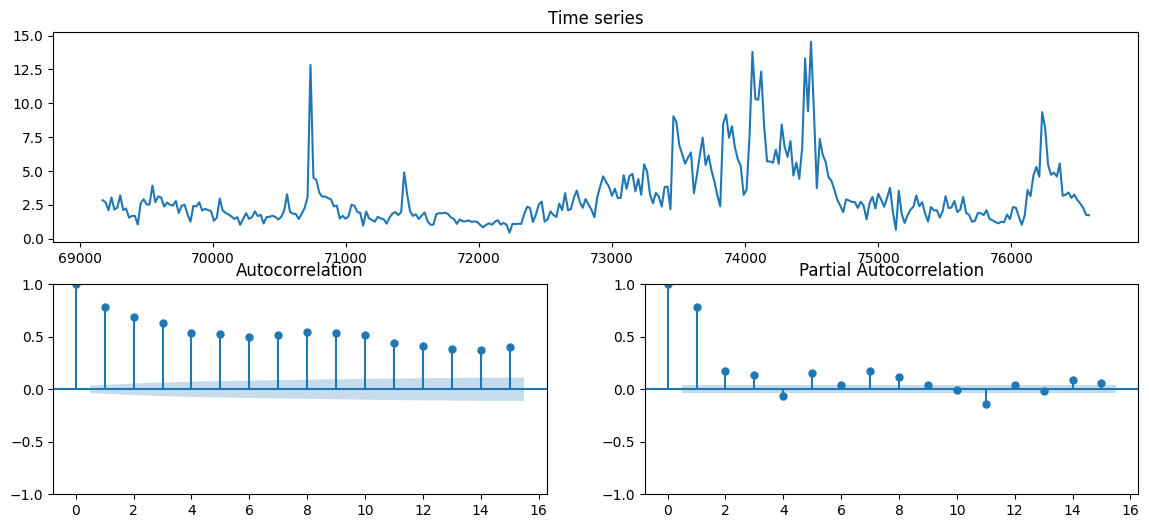

In [333]:
 tsplot(dfc)

- Pomoci tsplotu pozoruji casovou radu a ACF a PACF grafy. Podle prvniho pohledu to vypada, ze by se hodil AR(1) model. 
- Ted i z predchozich pozorovani lze uvazovat, ze bych cekal linearni zavislost Xt a Xt-1 (zatim neberu v potaz ze by nejspise bylo vhodne data derivovat kvuli existujicimu trendu, nebo jinak upravovat)

In [334]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [335]:
out = ar_select_order(dfc, maxlag=11, ic='aic', trend='n')
print("Proposed orders: ", out.ar_lags)

Proposed orders:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


/home/dave/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dave/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


- Jelikoz k casove rade pristupuji zatim naivne, tak mi bylo ar_select_order doporuceno pvnich 8 lagu. Vice nez 3 by nebylo vhodne vyuzit a indikovalo by to, ze je potreba data vice upravit, nez se je budu snazit popsat modelem.
- V nasledujici casti zkusim AR modely s prvnimi 4 lagy, vyhodnotim, ktery z nich se pro data nejvice hodi, podle testu a hodnot ziskanych funkci summary()

In [336]:
model_ar1 = AutoReg(dfc, lags=1, trend='c')
res_ar1 = model_ar1.fit()
print(res_ar1.summary())

                            AutoReg Model Results                             
Dep. Variable:                    ibi   No. Observations:                  338
Model:                     AutoReg(1)   Log Likelihood                -593.076
Method:               Conditional MLE   S.D. of innovations              1.406
Date:                Sun, 18 Dec 2022   AIC                           1192.153
Time:                        19:17:05   BIC                           1203.613
Sample:                             1   HQIC                          1196.721
                                  338                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6594      0.130      5.079      0.000       0.405       0.914
ibi.L1         0.7874      0.034     23.415      0.000       0.721       0.853
                                    Roots           

/home/dave/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


- Nejjednodussi AR(1) s trendem ukazuje, ze AR.1 lezi venku z jednotkove kruznice a tedy se plati **slaba stacionarita**

In [337]:
model_ar3 = AutoReg(dfc, lags=3, trend='c')
res_ar3 = model_ar3.fit()
print(res_ar3.summary())

                            AutoReg Model Results                             
Dep. Variable:                    ibi   No. Observations:                  338
Model:                     AutoReg(3)   Log Likelihood                -582.352
Method:               Conditional MLE   S.D. of innovations              1.376
Date:                Sun, 18 Dec 2022   AIC                           1174.703
Time:                        19:17:06   BIC                           1193.774
Sample:                             3   HQIC                          1182.306
                                  338                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4733      0.136      3.492      0.000       0.208       0.739
ibi.L1         0.6278      0.054     11.596      0.000       0.522       0.734
ibi.L2         0.0873      0.064      1.366      0.1

/home/dave/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


- Jelikoz AR(1) je prilis jednoduchy a vyplati se kouknout jak si vedou AR vyssich radu
- Pro AR(3) lze pozorovat, ze opet plati podminka slabe stacionarity a to aby koreny charakteristickeho polynomu byly > 1, coz zde opet plati
- Pro Informacni kriteria lze pozorovat o neco lepsi

In [338]:
model_ar4 = AutoReg(dfc, lags=4, trend='c')
res_ar4 = model_ar4.fit()
print(res_ar4.summary())

                            AutoReg Model Results                             
Dep. Variable:                    ibi   No. Observations:                  338
Model:                     AutoReg(4)   Log Likelihood                -580.396
Method:               Conditional MLE   S.D. of innovations              1.375
Date:                Sun, 18 Dec 2022   AIC                           1172.792
Time:                        19:17:06   BIC                           1195.659
Sample:                             4   HQIC                          1181.910
                                  338                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4995      0.138      3.618      0.000       0.229       0.770
ibi.L1         0.6365      0.055     11.656      0.000       0.529       0.744
ibi.L2         0.0924      0.064      1.442      0.1

/home/dave/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


- Oproti predchozimu AR(3) dosahuje AR(4) a lehce lepsich vysledku, porovnavaje AIC, BIC a HQIC
- Vypada to tedy, ze pro neupravene data ze s vysujicim lagem model o male krucky zlepsuje, ale tyto kurcky jsou velmi male
- Taktez u AR(4) lze pozorovat, ze p hodnota L4 je <= 0.5 a tedy k zamitnuti hypotezy H0. Koeficient neni statisticky vyznamne odlisny od nuly, podobne jako L3. V modelu bych jej tedy mel vynechat. Tanto model vsak vyuzivam k exploraci casove rady a jaky nani ma efekt jednoduchy AR model. 

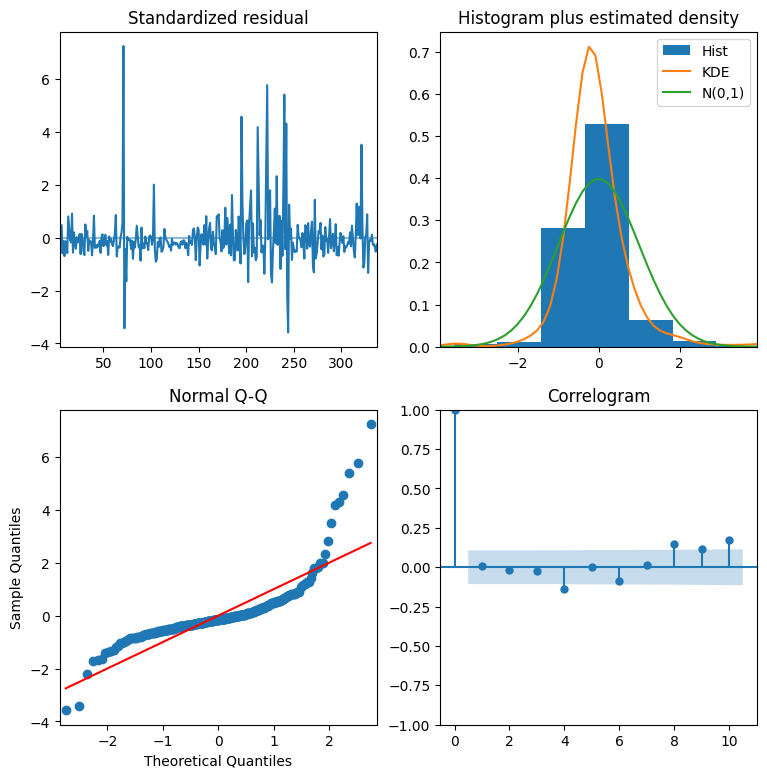

In [339]:
res_ar4.plot_diagnostics(figsize=(9,9))
plt.show()

- Z predchozich grafu lze vypozorovat jaky prubeh maji rezidua, znacne outliners systematicnosti... na ty bude treba se dale zamerit
- Histogram a jadrovy odhad (kde) vykazuji ze sice centrovane jsou kolem nuly, tak nemaji podobny rozptyl (mensi) (treba se taktez zamerit dale v programu)
- Q-Q plot ukazuje, ze kvantily rezidui na primce odpovidaji kvantilum gaussovky, az tedy na konec, kde to znatelne ujizdi
- Korelogram ukazuje, ze data jsou vzajemne mene korelovana

#### Zpracovani casove rady
- Predchozi modely jakz takz dosahovaly zajimavych vysledku, avsak u casove rady neni vhodne ji vzit bez hlubsi analyzi a predzpracovani
- Pomoci Box-Jenkinsonova pristupu vime, ze je treba si polozit na zacatku vice otazek, nez budeme fitovat jakykoliv model. 
- Je casova rada stacionarni ci ne? je na ni sezonost? atd...
- Aby byl statisticky model co nejjednodussi, tak je treba prave data zpracovat pred modelovanim

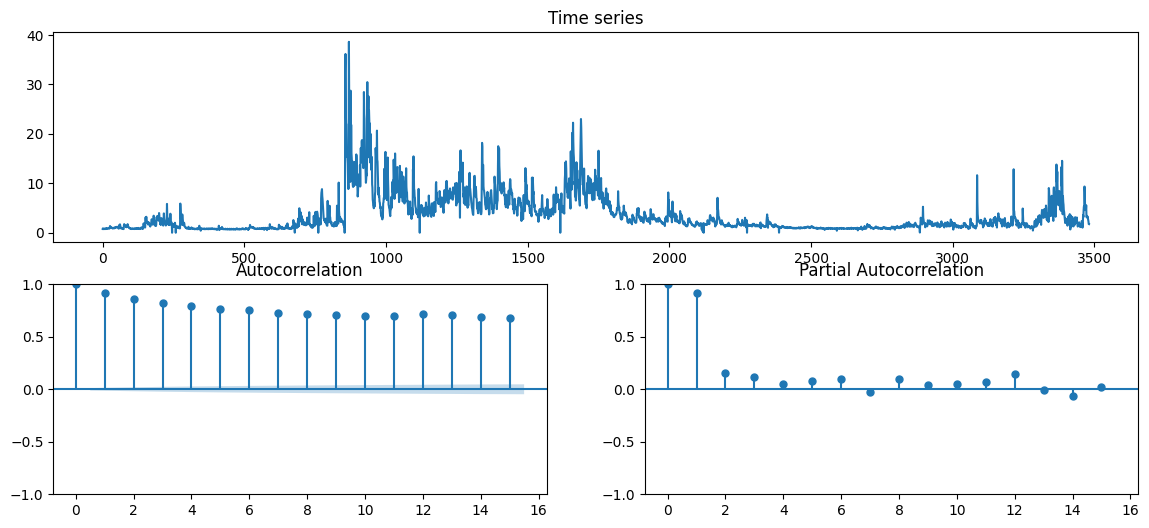

In [340]:
tsplot(df[df.sensor_id == 2]['ibi'].values)

- Jako prvni si vykresluji (znovu) jak casova rada vypada. Nyni vsak budu brat vsechny data, od roku 2013
- Z prvniho zpozdeni na PACF lze pozorovat, ze je tato hodnota velmi blizka 1.0. Coz indikuje, ze se v casove rade nejspise nachazi nahodna prochazka, kterou je treba vyresit
- Toto vyresim pomoci diferencovani casove rady, odecteni Xt od Xt-1
- Timto z rady odstranim trend.
- Nez to vsak udelam, tak je treba si rici, jeslti se v dateh nenachazi vice nez jeden model, mezi honoty cca 600 az 2500 to vypada na jeden model, od 2500 po soucasnost pak na dalsi
- **Pro dalsi zpracovani si tedy vezmu data od teto hodnoty po soucasnost, nebot na hodinach jsme si rikali, ze neni vhodne brat v potaz davnou minulost, viz covid grafy, kde jednotlive vlny byly popisovany ruznymi modely**

/tmp/ipykernel_6320/311100655.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tsplot(df[df.year == 2022][df.sensor_id == 2]['ibi'].values)


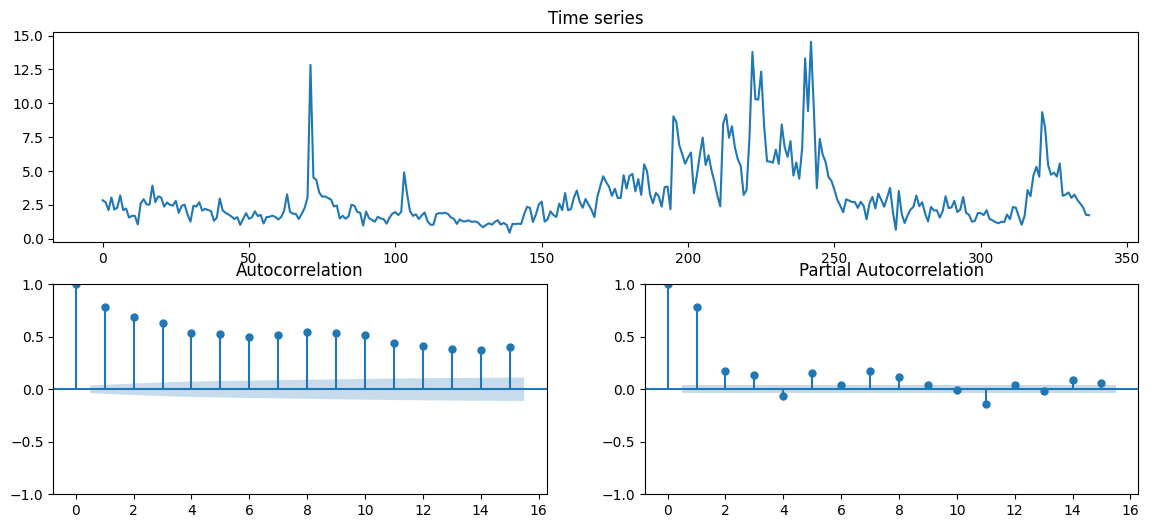

In [341]:
tsplot(df[df.year == 2022][df.sensor_id == 2]['ibi'].values)

- Tato casova rada je vice vypovidajici
- Opet pozorujeme, ze prvni zpozdeni PACF grafu je velmi blizke 1, coz vypovida o tom, ze by se v rade mohla nachazet nahodna prochazka a tedy trend, ktereho je treba se zbavit
- Zatim neberu v potaz transformaci, ktera bude nejspise treba

/tmp/ipykernel_6320/701149855.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dff = df[df.year == 2022][df.sensor_id == 2]['ibi'].values


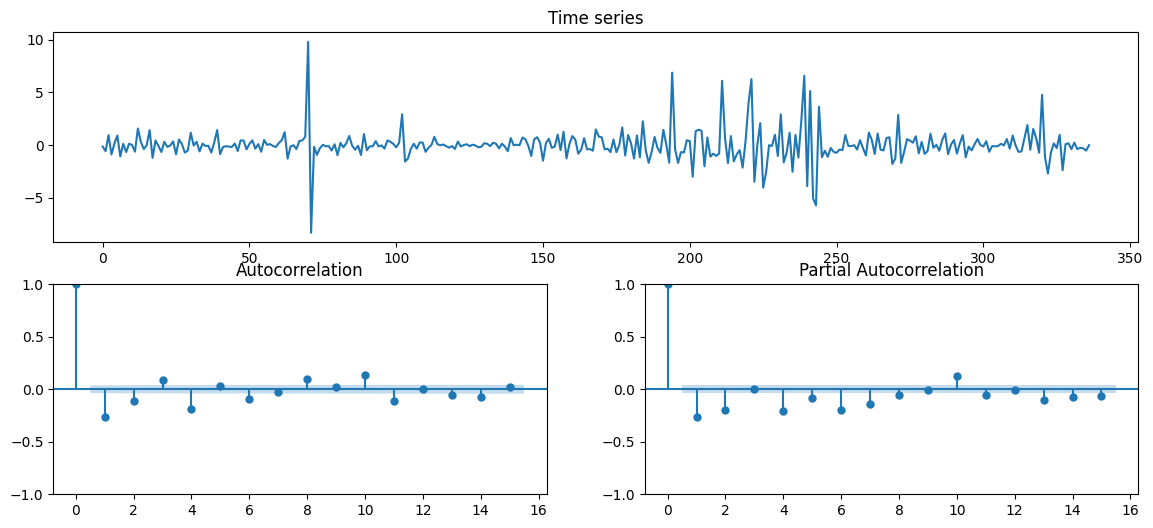

In [342]:
dff = df[df.year == 2022][df.sensor_id == 2]['ibi'].values
data_d1 = dff[1:] - dff[:-1]
tsplot(data_d1)

- Po prvni difirenci casove rady vidime, ze jsme ziskali radu novou, ve ktere se znacne meni variance (bude treba transformace)
- Nyni prichazi cas na nalezeni vhodneho modelu
- Hledani vnodnych parametru ARMA modelu, lze hrubou silou, zkousenim vsech moznych kombinaci hodnot parametru, ale lepsi metodou je MLE. (vyuziji funkci ze stats model pro nalezeni techto parametru)

In [343]:
from statsmodels.tsa.stattools import arma_order_select_ic

arma_order_select_ic(data_d1, trend='c', ic='aic', max_ar=4)

/home/dave/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/dave/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'aic':              0            1            2
 0  1227.932637  1195.010005  1183.002597
 1  1206.148708  1175.605647  1176.963080
 2  1195.433276  1194.436090  1177.363974
 3  1197.418159  1178.502246  1174.324940
 4  1185.230222  1170.535694  1171.377312,
 'aic_min_order': (4, 1)}

- Ze ziskanych dat lze pozorovat, ze bez transformace dat funkce pomoci aic kriteria doporucila AR(4) a MA(1). Coz ukazuje, ze se nejedna o vhodne nastaveni a casovou radu bude treba jeste upravit (jelikoz jsem nastavil max_ar na 4)

In [344]:
from statsmodels.tsa.arima.model import ARIMA

arma = ARIMA(data_d1, order=(4,0,1), trend='n').fit()
print(arma.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  337
Model:                 ARIMA(4, 0, 1)   Log Likelihood                -578.269
Date:                Sun, 18 Dec 2022   AIC                           1168.537
Time:                        19:17:10   BIC                           1191.458
Sample:                             0   HQIC                          1177.673
                                - 337                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4294      0.080      5.390      0.000       0.273       0.586
ar.L2          0.0023      0.042      0.054      0.957      -0.080       0.084
ar.L3          0.0883      0.048      1.847      0.0

- Z nastavenych parametru ARMA modelu lze pozorovat, ze AIC i BIC dosahuje dosti podobnych hodnot, jako samotne AR(4). 
- Pro parametr ar.L4 zamitame hypotezu H0 a meli bychom zmensit p parametr modelu
- Z testu dale nemohu zamitnout, ze jsou data nekorelovana (prob Q)
- Pro testy hereroskedasticity zamitame hypotezu H0 (0.05<=0.05), tedy zamitam ze data nejsou heteroske..
- Taktez zamitame ze data maji vyberovou sikmost a spicatost podobnou normalnimu rozdeleni (gaussovce)

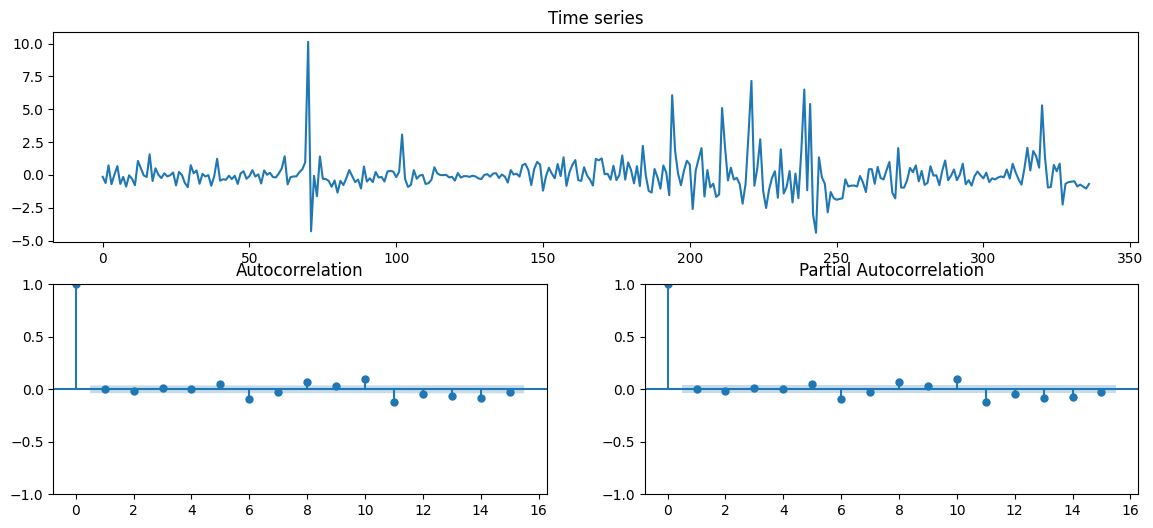

In [345]:
tsplot(arma.resid)
plt.show()

- Z redidui toho nelze moc rici, ani u ACF ani u PACF

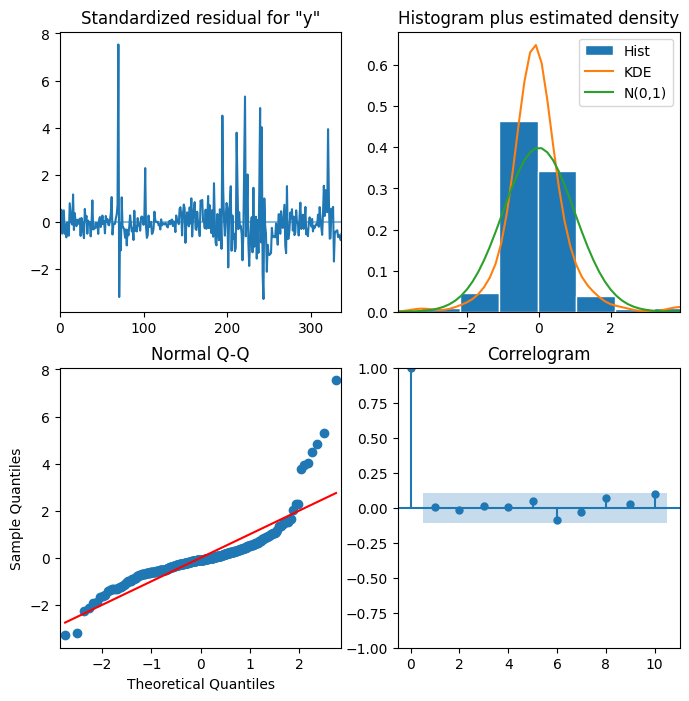

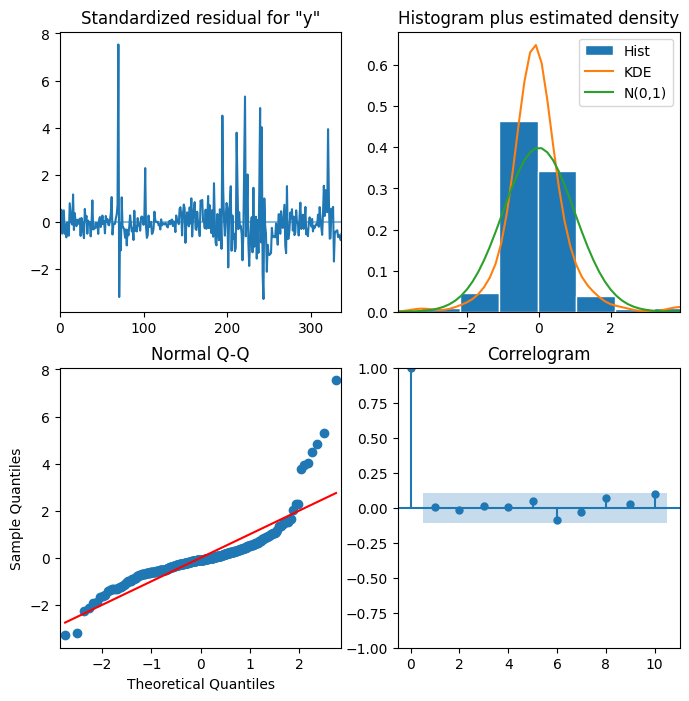

In [346]:
 arma.plot_diagnostics(figsize=(8,8))

- Z grafu vyse lze pozorovat, ze se mirne zlepsily kvantily rezidui, histogram je vice centrovany k 0, ale KDE je stale oproti N(0,1) uzsi a spicatejsi
- Vse ukazuje na to, ze by bylo vhodne data transformovat, abychom se zbavili (pokusili) zmeny variance

### Transformace dat
- Hlavni zbyvajici problem u dat je ten, ze data nejsou normalne distribuovana. Coz usti k spicatejsi distribuci s mensim rozptylem zakrivenou na pravou stranu.
- V posledni casti programu zkusim data transformovat a to dvema metodami
- Prvne vyuziji BoxCox.

In [347]:
tdf = df[df.year == 2022][df.sensor_id == 2][['time_stamp', 'tbi', 'ibi', 'sbi', 'obi']]

/tmp/ipykernel_6320/1004571005.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tdf = df[df.year == 2022][df.sensor_id == 2][['time_stamp', 'tbi', 'ibi', 'sbi', 'obi']]


- Z dat si vybiram pouze urcite sloupce roku 2022

In [348]:
ibi_2_vals = tdf['ibi'].values
fit_ibi_2_vals, fit_ibi_2_lambda = stats.boxcox(ibi_2_vals)

- Aplikuji transformaci boxcox ze stats modelu
- Opet vyuzivat 'ibi' sloupec (hodnoty vnejsiho pasu)

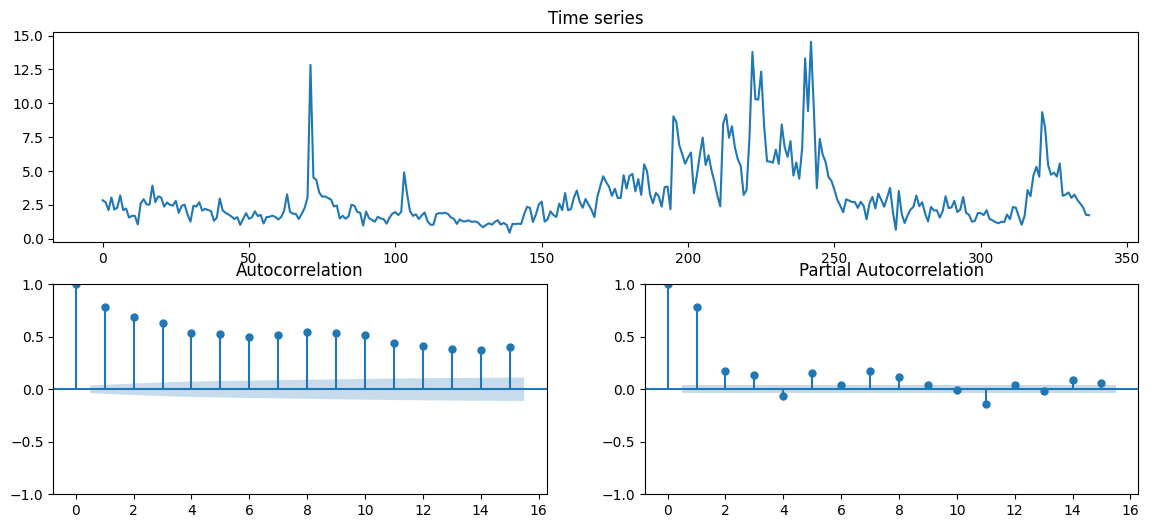

In [349]:
tsplot(tdf['ibi'].values)

/tmp/ipykernel_6320/1164367107.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ibi_2_vals, hist = False, kde = True,
/home/dave/.local/lib/python3.10/site-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/tmp/ipykernel_6320/1164367107.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility

Lambda value used for Transformation: -0.3213596270962609


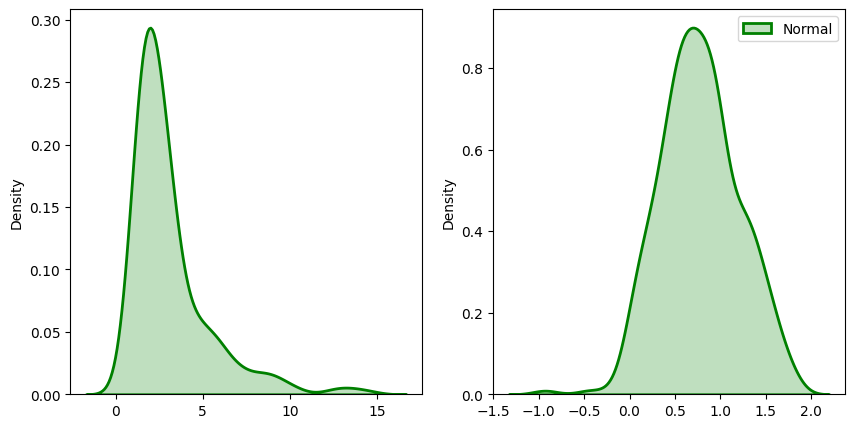

In [350]:
# kod zkopirovan z https://www.geeksforgeeks.org/box-cox-transformation-using-python/
# creating axes to draw plots
fig, ax = plt.subplots(1, 2)

# plotting the original data(non-normal) and
# fitted data (normal)
sns.distplot(ibi_2_vals, hist = False, kde = True,
    kde_kws = {'shade': True, 'linewidth': 2},
    label = "Non-Normal", color ="green", ax = ax[0])

sns.distplot(fit_ibi_2_vals, hist = False, kde = True,
    kde_kws = {'shade': True, 'linewidth': 2},
    label = "Normal", color ="green", ax = ax[1])

# adding legends to the subplots
plt.legend(loc = "upper right")

# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

print(f"Lambda value used for Transformation: {fit_ibi_2_lambda}")

- Predesly kod mi generuje data pred transformaci a po
- Lze pozorovat, ze predem se jednalo o ne-normalni distribuci a po transformaci o normalnejsi distribuci (blizko normalni distribuci)
- Boxcox nefunguje vzdy, negarantuje normalitu, protoze nekontroluje normalitu. Pouze kontroluje standartni deviaci. Proto je treba si data vykreslit a zkontrolovat, zdali byla transformace uspesna, coz v mem pripade ano.

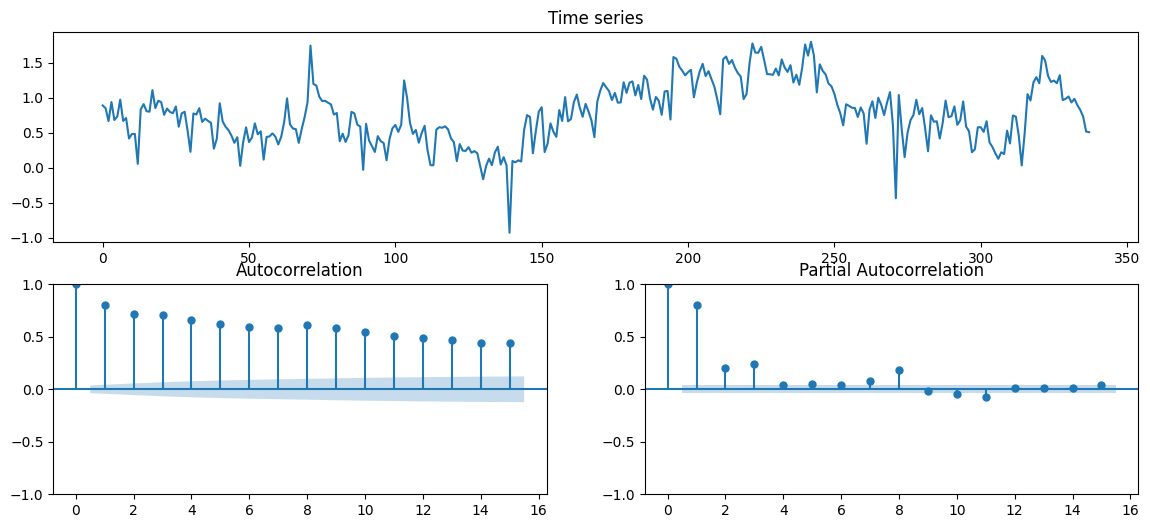

In [351]:
tsplot(fit_ibi_2_vals)

- Po transformaci si opet vykresluji casovou radu a lze pozorovat, ze je variance o dost lepsi (data dosahuji hodnot maximalne 1.5, drive az 15.0)

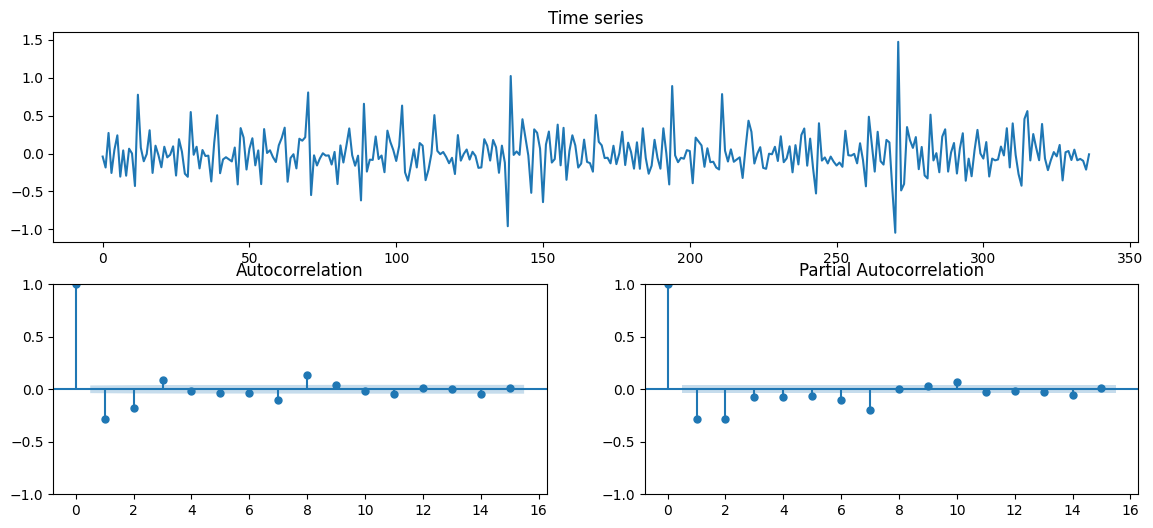

In [352]:
data_d1 = fit_ibi_2_vals[1:] - fit_ibi_2_vals[:-1]
tsplot(data_d1)

- Po transformaci je treba data diferencovat, neboli prvni zpozdeni v PACF ukazuje, ze by se tam asi nachazela nahodna prochazka, plus je treba se zbavit trendu
- Po diferenci uz se z ACF ani PACF neda moc poznat, tak vyzkousim zjistit nastaveni ARMA modelu a nafitovat jej na casovou radu

In [353]:
arma_order_select_ic(data_d1, trend='n', ic='bic', max_ar=4)

/home/dave/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/dave/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/dave/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'bic':            0          1          2
 0  71.636445  26.015387  19.600970
 1  49.697836  20.829433  25.142265
 2  27.595513  26.429225  30.481131
 3  31.807870  27.567141  33.209962
 4  35.767275  33.164942  39.206964,
 'bic_min_order': (0, 2)}

- Funci arma_order_select_ic nastavuji bez trendu, jelikoz ten jsem v predchozim kroku snazil odstranit
- Pro aic i bic je doporuceno pouzit arma model ARMA(0, 2), neboli AR(0) a MA(2)
- V dalsi casti takto nastavim ARMA model

In [354]:
arma = ARIMA(data_d1, order=(0,0,2), trend='n').fit()
print(arma.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  337
Model:                 ARIMA(0, 0, 2)   Log Likelihood                  -1.070
Date:                Sun, 18 Dec 2022   AIC                              8.141
Time:                        19:17:16   BIC                             19.601
Sample:                             0   HQIC                            12.709
                                - 337                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4051      0.036    -11.140      0.000      -0.476      -0.334
ma.L2         -0.2140      0.054     -3.950      0.000      -0.320      -0.108
sigma2         0.0589      0.003     20.190      0.0

- Po nafitovani modelu ARMA(0,2) (neboli ARIMA(0,1,2) protoze jsem data diferencoval) na transformovanych datech lze pozorovat znacne zlepseni kvality modelu, oproti predeslym. Oproti Predeslym modelum jsou hodnoty AIC, BIC i HQIC znatelne lepsi (predem se tyto hodnoty pohybovaly v radu tisicu).
- Pro test Ljung-Box plati, ze nelze zamitnout ze by data nebyly korelovane
- Pro test Heteroskedacity nelze zamitnout, ze by data nebyly heterosked.
- Pro test JB zamitame hypotezu, ze by data meli vyberovou spicatost a sikmost jako N(0, 1)

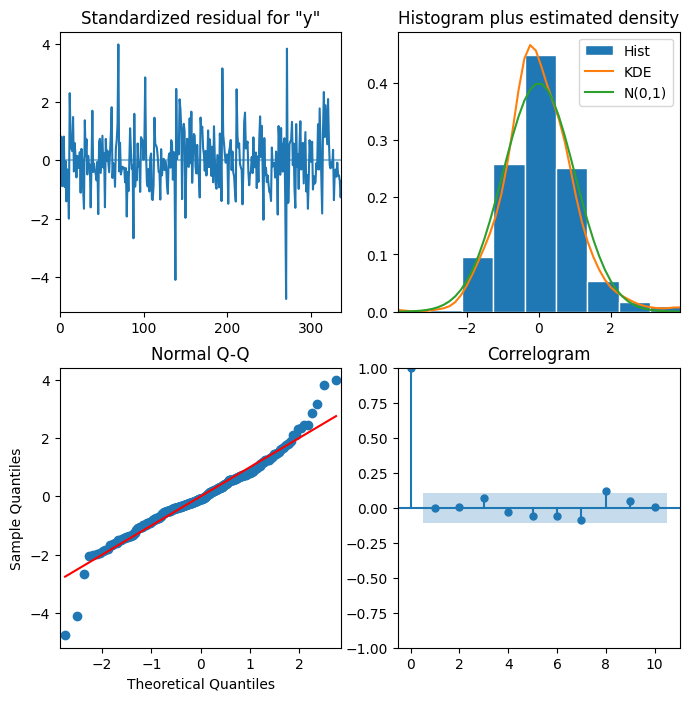

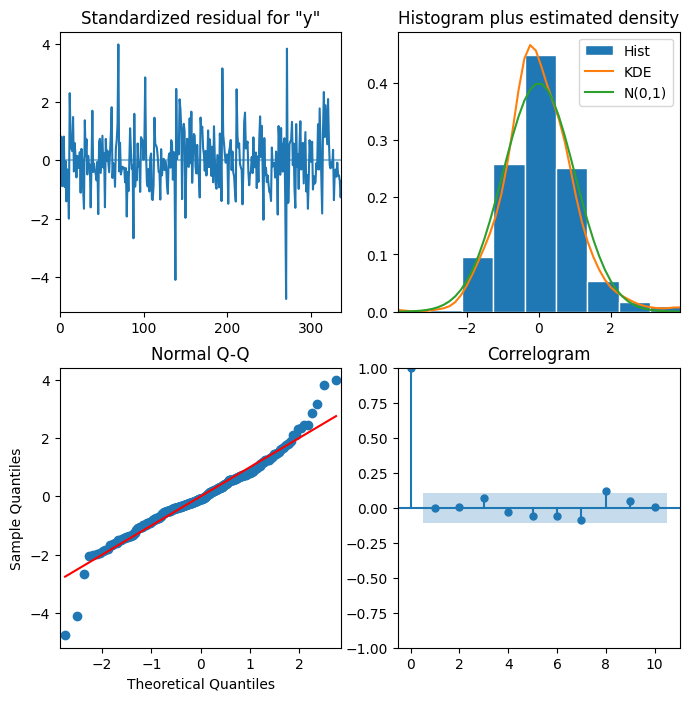

In [355]:
 arma.plot_diagnostics(figsize=(8,8))

- Z grafu lze pozorovat znatelne zlepseni histogramu, neboli distribuce rezidui je o neco spicatejsi nez normalni, ale je ji znatelne blizsi 
- Zlepseni lze taktez pozorovat i na Q-Q grafu, neboli kvantil rezidui odpovice vice kvantilum teoretickym norm. rozdeleni. Konce nejsou tak moc odlehle.

#### Dalsi transformace
- V posledni casti se zameruji na transformaci dat pomoci odmocniny
- Po teto transformaci si provedu finalni porovnani a nafitovani dat ze senzoru natoceneho o 90 stupnu zaznamenavaji stejny rozptyl >100keV

In [356]:
tdf['sr_ibi'] = tdf['ibi'].apply(lambda x: x ** (1/2))

- Transformaci dat provedu vytvorenim noveho sloupce s prepocitanymi hodnotami

/tmp/ipykernel_6320/868494259.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tdf.ibi.values, hist = False, kde = True,
/home/dave/.local/lib/python3.10/site-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/tmp/ipykernel_6320/868494259.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibilit

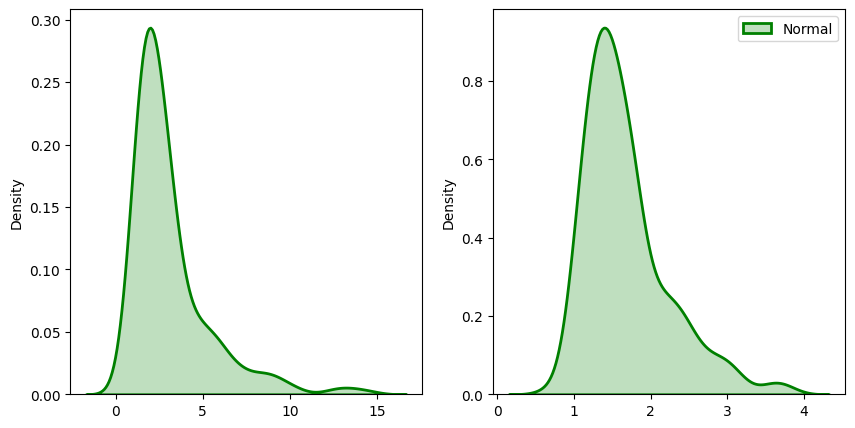

In [357]:
fig, ax = plt.subplots(1, 2)

# plotting the original data(non-normal) and
# fitted data (normal)
sns.distplot(tdf.ibi.values, hist = False, kde = True,
    kde_kws = {'shade': True, 'linewidth': 2},
    label = "Non-Normal", color ="green", ax = ax[0])

sns.distplot(tdf.sr_ibi.values, hist = False, kde = True,
    kde_kws = {'shade': True, 'linewidth': 2},
    label = "Normal", color ="green", ax = ax[1])

# adding legends to the subplots
plt.legend(loc = "upper right")

# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

- Pro odmocninu jsem zvolil 1/2
- Z grafu lze pozorovat, ze vysledek neni tak dobry, jak tomu bylo u boxcox

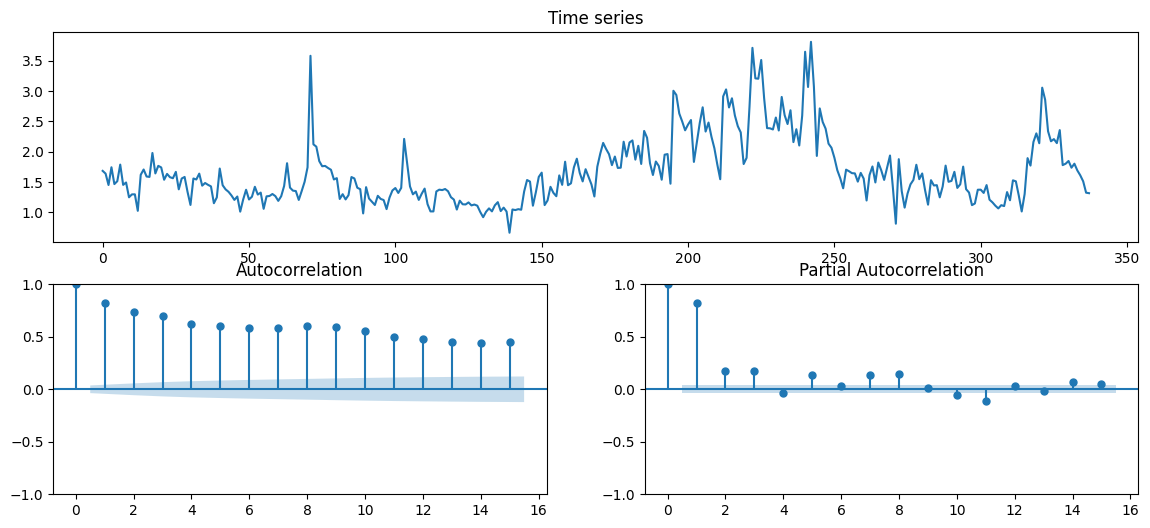

In [358]:
tsplot(tdf.sr_ibi.values)

- Z PACF lze opet pozorovat, ze se v grafu nachazi nejspise nahodna prochazka a urcity trend, ktereho je treba se zbavit diferencovanim

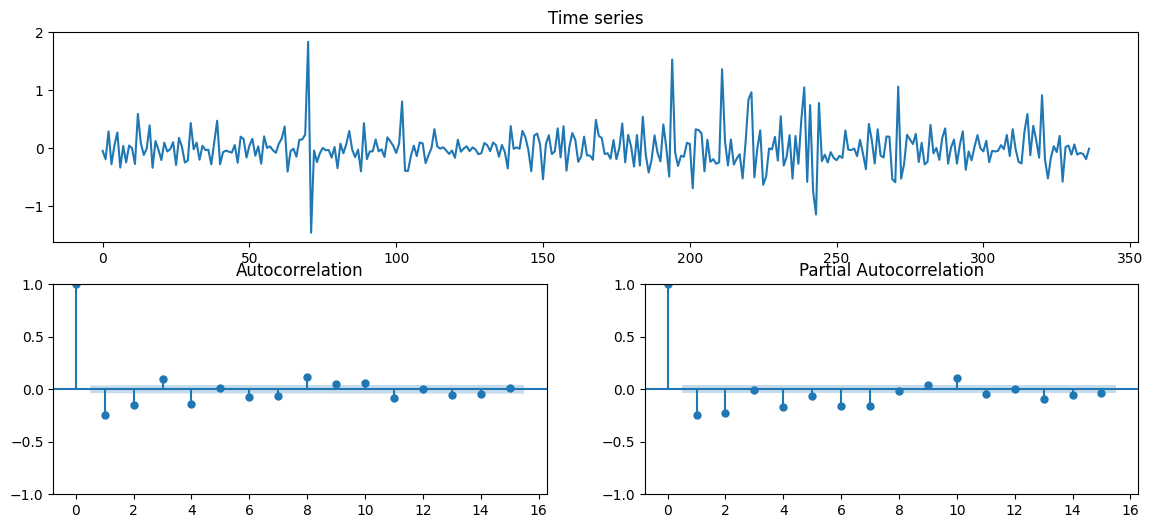

In [359]:
data_d1 = tdf.sr_ibi.values[1:] - tdf.sr_ibi.values[:-1]
tsplot(data_d1)

- Klasicke diferencovani zbavilo casovou radu trendu a zbyva na vyslednou casovou radu nafitovat prislusny ARMA model

In [360]:
arma_order_select_ic(data_d1, trend='n', ic='bic', max_ar=4)

/home/dave/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dave/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'bic':             0           1           2
 0  205.427678  178.105594  169.321494
 1  190.608842  166.585977  172.230592
 2  179.249528  172.293564  173.799745
 3  185.056417  175.973275  177.076395
 4  181.455120  176.100695  181.246307,
 'bic_min_order': (1, 1)}

- Funkci arma_order_select_ic bylo doporuceno nastaveni ARMA(1,1) a to tedy vyzkousim

In [361]:
arma = ARIMA(data_d1, order=(1,0,1), trend='n').fit()
print(arma.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  337
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -74.563
Date:                Sun, 18 Dec 2022   AIC                            155.126
Time:                        19:17:20   BIC                            166.586
Sample:                             0   HQIC                           159.694
                                - 337                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4937      0.074      6.655      0.000       0.348       0.639
ma.L1         -0.8447      0.053    -15.855      0.000      -0.949      -0.740
sigma2         0.0910      0.003     28.664      0.0

- Oproti transformaci boxcox ma tento model po sqr transformaci horsi vysledky AIC, BIC i HQIC
- A tedy mezi temito dvema transformacemi a modely volim ten predesli postup, nebot dosahuje lepsich vysledku

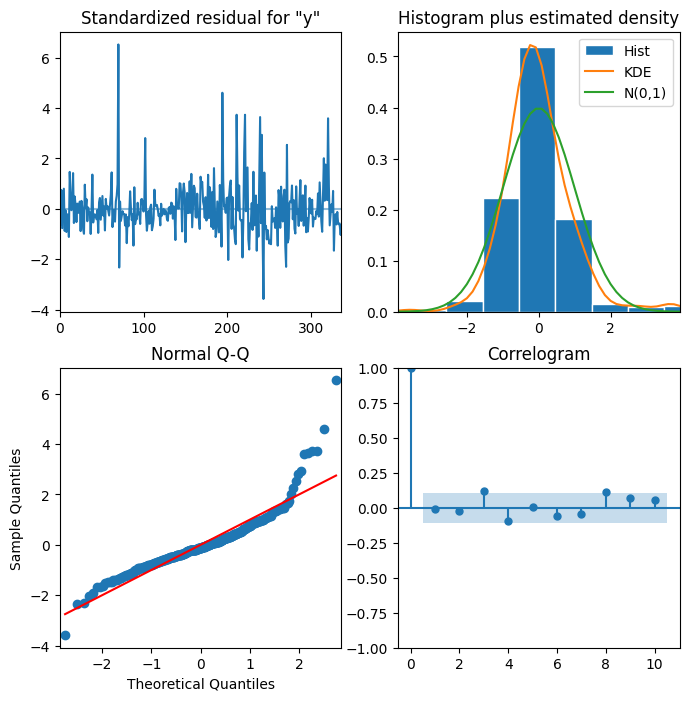

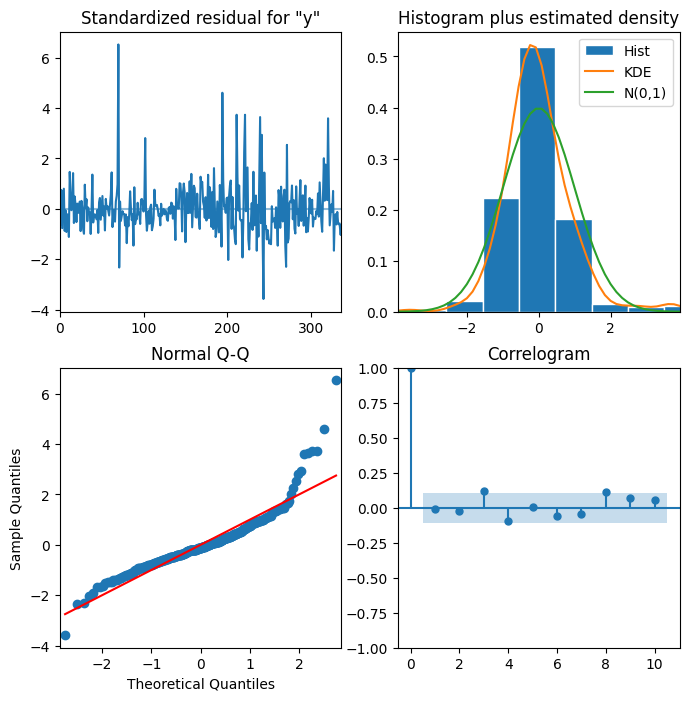

In [362]:
 arma.plot_diagnostics(figsize=(8,8))

- Tento fakt lze pozorovat i na predchozich grafech, distribuce residui je mene podobna normalnimu rozdeleni a kvantily residui maji vetsi tendenci ujizdet na stranach grafu Q-Q
- **Po techto pozorovanich tedy nejdrive casovou radu ziskanou z namerenych dat senzoru 2 satelitu NOAA_19 transformuji pomoci boxcox a nasledne vyuziji model ARIMA(0,1,2)** neb dosahuje ze vsech pozorovanych nejlepsich vysledku a tento model tuto casovou radu popisuje nejlepe

#### Vyuziti modelu ARIMA(0,1,2) na senzoru 3 (senzor 2 otoceny o 90 stupnu)
- Pro finalni cast tohoto ukolu bych se rad zameril na vliv ktery ma natoceni senzoru na zaznamenana data, proto vyzkousim nejlepsi model pro senzor 2 vyuzit na senzoru 3

In [363]:
tdf = df[df.year == 2022][df.sensor_id == 3][['time_stamp', 'tbi', 'ibi', 'sbi', 'obi']]

ibi_3_vals = tdf['ibi'].values

/tmp/ipykernel_6320/1048064865.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tdf = df[df.year == 2022][df.sensor_id == 3][['time_stamp', 'tbi', 'ibi', 'sbi', 'obi']]


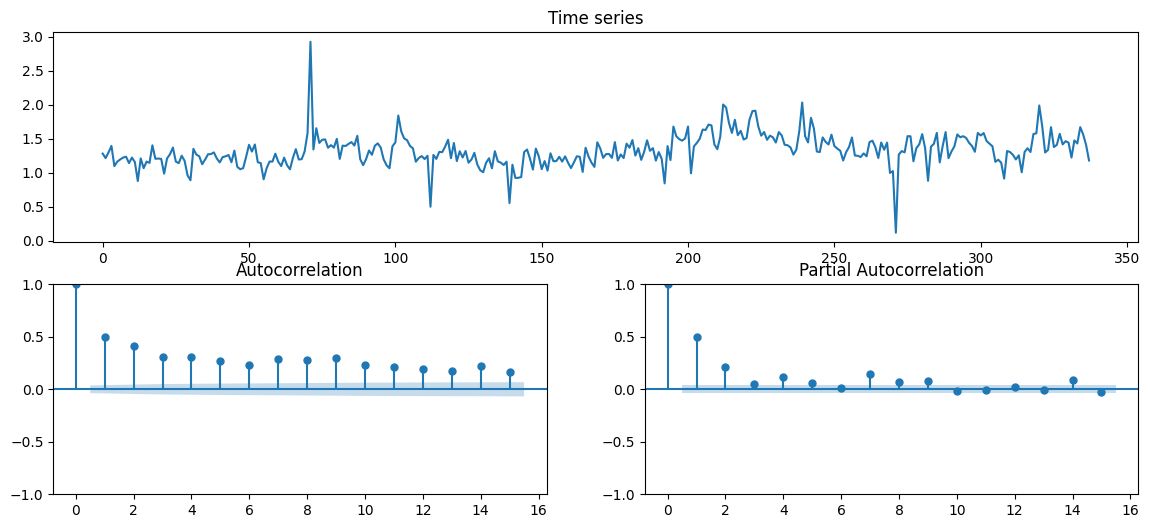

In [364]:
tsplot(ibi_3_vals)

- Ze zobrazenych ACF a PACF lze pozorovat, ze prvni zpozdeni PACF se nenachazi blizko hodnoty 1.0 ale na stredu, tedy je na zvazeni, jestli je treba data diferencovat, zdali, by neslo pouzit lehci model nez ARIMA(0,1,2) treba AR(1)

In [365]:
fit_ibi_3_vals, fit_ibi_3_lambda = stats.boxcox(ibi_3_vals)

arma = ARIMA(fit_ibi_3_vals, order=(0,1,2), trend='n').fit()
print(arma.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  338
Model:                 ARIMA(0, 1, 2)   Log Likelihood                  70.350
Date:                Sun, 18 Dec 2022   AIC                           -134.700
Time:                        19:17:22   BIC                           -123.240
Sample:                             0   HQIC                          -130.132
                                - 338                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6686      0.040    -16.805      0.000      -0.747      -0.591
ma.L2         -0.1612      0.053     -3.040      0.002      -0.265      -0.057
sigma2         0.0384      0.001     32.052      0.0

- Ze ziskaneho shrunuti lze vypozorovat, ze se dle AIC a BIC nepohybuje kvalita modelu tomu u senzoru 2
- Nelze vyvratit hypotezu, ze by data nebyly korelovana
- Nelze vyvratit hypotezu, ze by data nebyly heteroskedasticitivni
- Vyvracujeme hypotezu, ze by data mely vyberevou sikmost a spicatost podobnou normalnimu rozdeleni

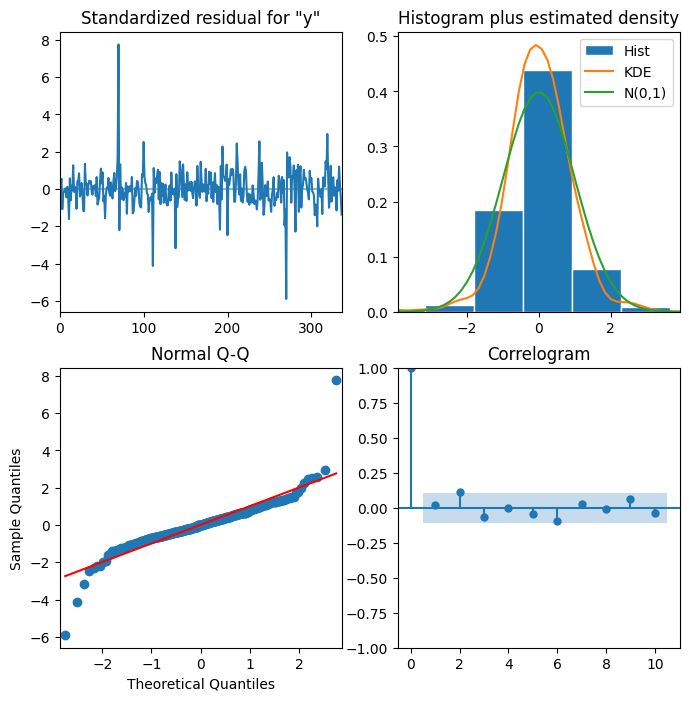

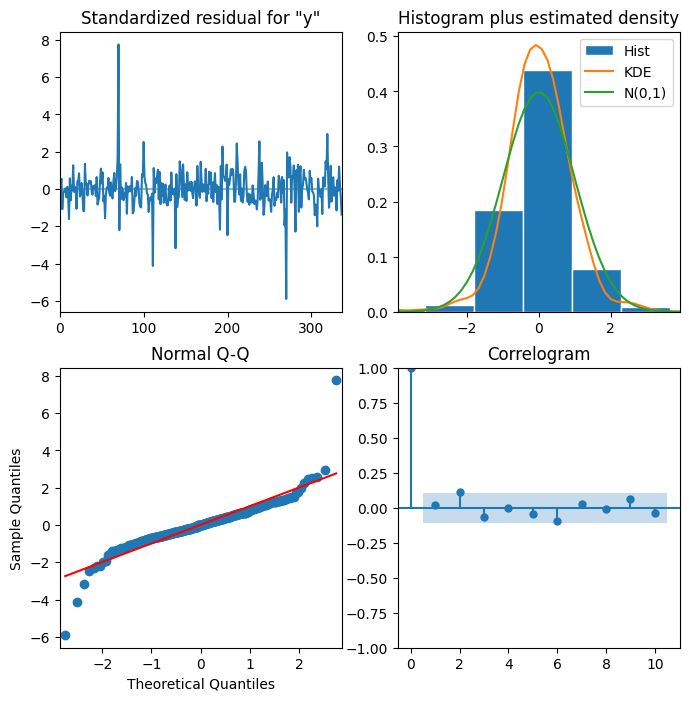

In [366]:
 arma.plot_diagnostics(figsize=(8,8))

- Z grafu vyse lze vycist, ze kvantili residui odpovidaji teoretickym kvantilum normalniho rozdeleni, sice na koncich maji odlehlejsi hodnoty.
- U histogramu lze videt, ze rozdeleni rezidui je centrovano u nuly a je lehce spicatejsi, majici mensi rozptyl
- **Na zodpovezeni otazky lze rici, ze model neni spatny, ale urcite by sel vybrat lepsi, ktery by vice pasoval na data ze senzoru 3**